In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel, GenericUnivariateSelect
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform
sns.set_style('darkgrid')

In [44]:
df_feats = pd.read_csv('df_feats.csv')
df_targets = pd.read_csv('df_targets.csv')

In [45]:
def _color_red_or_green(val):
    color = 'green' if val > 0.75 else ('orange' if val > 0.65 else 'black')
    return 'color: %s' % color

## Classifiers 

target - cesdclinmA (Depression - yes/no)

### Attempting to tune the hyper-parameters of the top models to see if results improve

#### Best RandomForestClassifier

In [46]:
X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

cols = X.columns

scaler = StandardScaler()

scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=cols)

rfc = RandomForestClassifier()

param_dict = {'n_estimators': np.arange(80,120), 'max_depth': np.arange(3,8), 'min_samples_leaf': np.arange(2,8),
             'criterion': ['gini', 'entropy'], 'min_samples_split': np.arange(2,8), 'max_features': 
              ['auto', 'sqrt', 'log2'], 'max_leaf_nodes': np.arange(3,12), 'n_jobs': [-1]}

tree_grid = RandomizedSearchCV(rfc, param_dict)
tree_grid.fit(X, y)
rfc = tree_grid.best_estimator_
rfc

RandomForestClassifier(max_depth=6, max_leaf_nodes=4, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=82, n_jobs=-1)

In [47]:
all_scores = {'Train_Accuracy_CV': [], 'Val_Accuracy_CV': [], 'Train_F1_CV': [], 
             'Val_F1_CV': [], 'Val_Sensitivity_CV': [], 'Val_Specificity_CV': [], 'Val_AUC_CV': [], 'K': []}


fs = PCA().fit(X, y)
array = np.cumsum(fs.explained_variance_ratio_)

K = np.argmax(array > 0.8)
fs = PCA(n_components=K).fit(X)
                 
X_pca = pd.DataFrame(fs.transform(X))

skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

final_results = []

all_y_preds = []
all_y_true = []

for train_index, val_index in skf.split(X_pca, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    rfc.fit(X_train, y_train)
    y_pred_train = rfc.predict(X_train)
    y_pred_val = rfc.predict(X_val)
    
    all_y_preds.append(list(y_pred_val))
    all_y_true.append(list(y_val))
    
    all_scores['Train_Accuracy_CV'].append(accuracy_score(y_train, y_pred_train))
    all_scores['Val_Accuracy_CV'].append(accuracy_score(y_val, y_pred_val))
    all_scores['Train_F1_CV'].append(f1_score(y_train, y_pred_train, average='weighted'))
    all_scores['Val_F1_CV'].append(f1_score(y_val, y_pred_val, average='weighted'))
    all_scores['Val_Sensitivity_CV'].append(recall_score(y_val, y_pred_val, average='weighted'))
    all_scores['Val_Specificity_CV'].append(recall_score(y_val, y_pred_val, labels = [0], average='weighted'))
    all_scores['Val_AUC_CV'].append(roc_auc_score(y_val, y_pred_val))
    all_scores['K'].append(K)

# Averaging CV results of splits
for metric, score in all_scores.items():
    all_scores[metric] = np.mean(score)
    
all_y_preds = [item for elem in all_y_preds for item in elem]
all_y_true = [item for elem in all_y_true for item in elem]
    
final_results.append({'Model': rfc.__class__.__name__, 'scaler': scaler.__class__.__name__, 
                              'Feat Selection': 'FDR',
                              'Type': 'CV',
                              'Num of Features': all_scores['K'],
                              'Train_Accuracy_CV': all_scores['Train_Accuracy_CV'], 
                              'Val_Accuracy_CV': all_scores['Val_Accuracy_CV'], 
                              'Train_F1_CV': all_scores['Train_F1_CV'], 
                              'Val_F1_CV': all_scores['Val_F1_CV'], 
                              'Val_Sensitivity_CV': all_scores['Val_Sensitivity_CV'], 
                              'Val_Specificity_CV': all_scores['Val_Specificity_CV'], 
                              'Val_AUC_CV': all_scores['Val_AUC_CV']})
pd.DataFrame(final_results).set_index(['Model'])

,scaler,Feat Selection,Type,Num of Features,Train_Accuracy_CV,Val_Accuracy_CV,Train_F1_CV,Val_F1_CV,Val_Sensitivity_CV,Val_Specificity_CV,Val_AUC_CV
Model,,,,,,,,,,,
RandomForestClassifier,StandardScaler,FDR,CV,14.0,0.912625,0.765,0.903378,0.664524,0.765,1.0,0.5


In [48]:
def coefs_to_df(cols, model, features_selected, scaler, dict_name, K_all, fs_method=None):
    """
    This function extracts the feature coefficients of a model and saves it in to a dataframe
    """ 
    
    tree_models = ['RandomForestRegressor', 'RandomForestClassifier', 'XGBClassifier']
    
    
    if model.__class__.__name__ in tree_models:
        
        coefs = model.feature_importances_
        
    else:
        
        coefs = model.coef_
     

    if fs_method == 'PCA':
        
        pca_coefs = features_selected.components_.T * coefs
        
        all_coefs = pca_coefs.sum(axis=1)
        
    else:
       
        coefs_vals = coefs.flatten().tolist()
    
        # getting indexes of remaining features' coefficients
        coefs_inds = [i for i, element in enumerate(features_selected.get_support()) if element == True]

        all_coefs = [coefs_vals[coefs_inds.index(i)] if i in coefs_inds else 0 for i in range(len(cols))]

    all_coefs_df = pd.DataFrame([all_coefs], columns=cols)
    all_coefs_df['Model'] = model.__class__.__name__
    all_coefs_df['Scaler'] = scaler.__class__.__name__
    all_coefs_df['Feat Selection'] = dict_name
    all_coefs_df['Type'] = 'All_data'
    all_coefs_df['Num of Features'] = K_all
    
    all_coefs_df.set_index(['Model', 'Scaler', 'Feat Selection', 'Type', 'Num of Features'], inplace=True) 
    
    return all_coefs_df

#### Random Forest Feature Importance (all data, no CV, PCA):

22


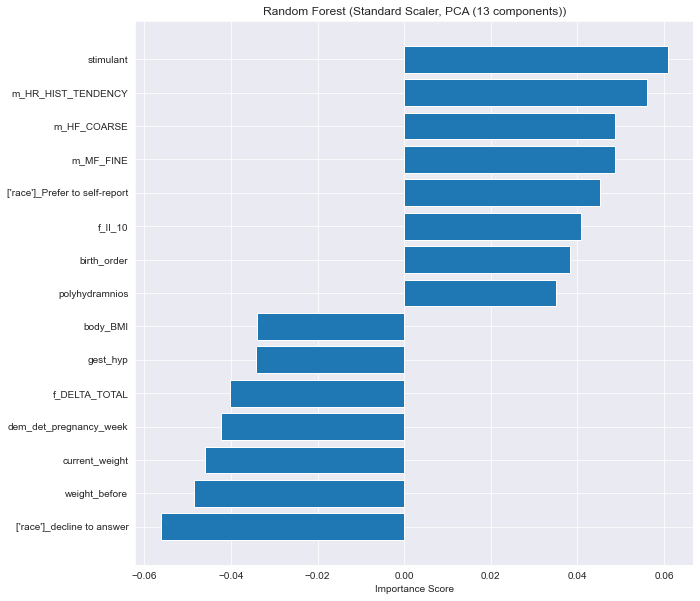

In [50]:
X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

cols = X.columns

pca = PCA()
fs = pca.fit(X)
array = np.cumsum(fs.explained_variance_ratio_)

# Selecting number of principal components
K = np.argmax(array > 0.9)
fs = PCA(n_components=K).fit(X)
X = fs.transform(X)
rfc = RandomForestClassifier(max_depth=5, min_samples_split=4, n_estimators = 200, min_samples_leaf=3)
rfc.fit(X, y)

coefs_df = coefs_to_df(cols, rfc, fs, scaler, 'PCA', K, 'PCA')

coefs_df = coefs_df.reset_index().drop(columns = ['Model', 'Scaler', 'Feat Selection', 'Type', 'Num of Features']).T. \
                                        sort_values(by=0, ascending=False)

pos_coefs = coefs_df[0][0:8]
neg_coefs = coefs_df[0][-7:]

strongest_coefs = pd.concat([pos_coefs, neg_coefs], axis=0)
strongest_coefs = pd.DataFrame(strongest_coefs)
strongest_coefs.rename(columns = {0 : "Coefficient"}, inplace=True)

plt.figure(figsize=(10,10))
plt.barh(strongest_coefs.index, strongest_coefs["Coefficient"])
plt.gca().invert_yaxis()
plt.title("Random Forest (Standard Scaler, PCA (22 components))")
plt.savefig('feat_imp_rfc_pca.png',bbox_inches="tight")
plt.xlabel('Importance Score');

#### Random Forest Feature Importance (all data, no CV, FPR):

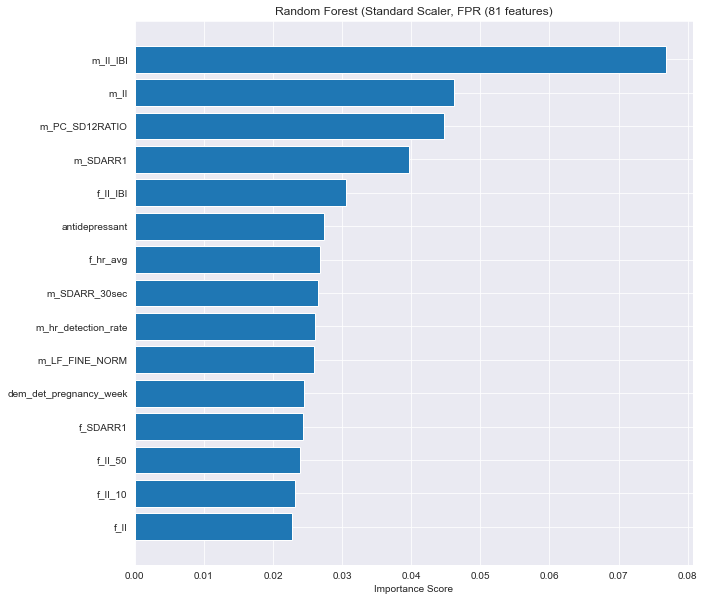

In [52]:
X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

cols = X.columns

fs = GenericUnivariateSelect(mode='fpr', param=0.5).fit(X, y)
K = sum(fs.get_support())
X = fs.transform(X)

rfc = RandomForestClassifier(max_depth=5, min_samples_split=4, n_estimators = 200, min_samples_leaf=3)

rfc.fit(X, y)

coefs_df = coefs_to_df(cols, rfc, fs, scaler, 'FPR', K)

coefs_df = coefs_df.reset_index().drop(columns = ['Model', 'Scaler', 'Feat Selection', 'Type', 'Num of Features']).T. \
                                        sort_values(by=0, ascending=False)

#pos_coefs = coefs_df[0][0:8]
#neg_coefs = coefs_df[0][-7:]

#strongest_coefs = pd.concat([pos_coefs, neg_coefs], axis=0)
strongest_coefs = pd.DataFrame(coefs_df)[0:15]
strongest_coefs.rename(columns = {0 : "Coefficient"}, inplace=True)

plt.figure(figsize=(10,10))
plt.barh(strongest_coefs.index, strongest_coefs["Coefficient"])
plt.gca().invert_yaxis()
plt.title("Random Forest (Standard Scaler, FPR (81 features)")
plt.savefig('feat_imp_rfc_fpr.png',bbox_inches="tight")
plt.xlabel('Importance Score');

#### Random Forest Feature Importance (all data, no CV, Lasso):

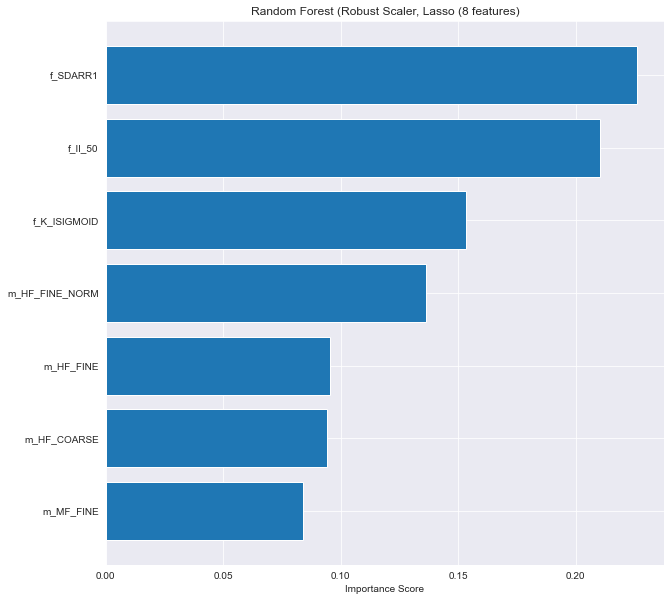

In [25]:
X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

scaler = RobustScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

cols = X.columns

fs = SelectFromModel(Lasso(alpha=0.15, max_iter=5000, tol=0.2))
fs.fit(X, y)
X = fs.transform(X)
K = sum(fs.get_support())

rfc = RandomForestClassifier(max_depth=5, min_samples_split=4, n_estimators = 200, min_samples_leaf=3)

rfc.fit(X, y)

coefs_df = coefs_to_df(cols, rfc, fs, scaler, 'Lasso', K)

coefs_df = coefs_df.reset_index().drop(columns = ['Model', 'Scaler', 'Feat Selection', 'Type', 'Num of Features']).T. \
                                        sort_values(by=0, ascending=False)

#pos_coefs = coefs_df[0][0:8]
#neg_coefs = coefs_df[0][-7:]

#strongest_coefs = pd.concat([pos_coefs, neg_coefs], axis=0)
strongest_coefs = pd.DataFrame(coefs_df)[0:7]
strongest_coefs.rename(columns = {0 : "Coefficient"}, inplace=True)

plt.figure(figsize=(10,10))
plt.barh(strongest_coefs.index, strongest_coefs["Coefficient"])
plt.gca().invert_yaxis()
plt.title("Random Forest (Robust Scaler, Lasso (8 features)")
plt.savefig('feat_imp_rfc_lasso.png',bbox_inches="tight")
plt.xlabel('Importance Score');

### Best XGBClassifier

In [26]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

xgb = XGBClassifier(use_label_encoder=False, eval_metric='error', eta=1)

param_dict = {'max_depth': (3, 18, 1),
        'gamma': (1,9),
        'reg_alpha' : (40,180,1),
        'reg_lambda' : (0,1),
        'colsample_bytree' : (0.5,1),
        'min_child_weight' : (0, 10, 1),
    }

grid = RandomizedSearchCV(xgb, param_dict)
grid.fit(X, y)
xgb = grid.best_estimator_
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=1,
              eval_metric='error', gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1, max_delta_step=0,
              max_depth=18, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=40, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [27]:
all_scores = {'Train_Accuracy_CV': [], 'Val_Accuracy_CV': [], 'Train_F1_CV': [], 
             'Val_F1_CV': [], 'Val_Sensitivity_CV': [], 'Val_Specificity_CV': [], 'Val_AUC_CV': [], 'K': []}

skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

final_results = []

all_y_preds = []
all_y_true = []

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    xgb.fit(X_train, y_train)
    y_pred_train = xgb.predict(X_train)
    y_pred_val = xgb.predict(X_val)
    
    all_y_preds.append(list(y_pred_val))
    all_y_true.append(list(y_val))
    
    all_scores['Train_Accuracy_CV'].append(accuracy_score(y_train, y_pred_train))
    all_scores['Val_Accuracy_CV'].append(accuracy_score(y_val, y_pred_val))
    all_scores['Train_F1_CV'].append(f1_score(y_train, y_pred_train, average='weighted'))
    all_scores['Val_F1_CV'].append(f1_score(y_val, y_pred_val, average='weighted'))
    all_scores['Val_Sensitivity_CV'].append(recall_score(y_val, y_pred_val, average='weighted'))
    all_scores['Val_Specificity_CV'].append(recall_score(y_val, y_pred_val, labels = [0], average='weighted'))
    all_scores['Val_AUC_CV'].append(roc_auc_score(y_val, y_pred_val))

# Averaging CV results of splits
for metric, score in all_scores.items():
    all_scores[metric] = np.mean(score)
    
all_y_preds = [item for elem in all_y_preds for item in elem]
all_y_true = [item for elem in all_y_true for item in elem]
    
final_results.append({'Model': xgb.__class__.__name__,
                              'Type': 'CV',
                              'Num of Features': all_scores['K'],
                              'Train_Accuracy_CV': all_scores['Train_Accuracy_CV'], 
                              'Val_Accuracy_CV': all_scores['Val_Accuracy_CV'], 
                              'Train_F1_CV': all_scores['Train_F1_CV'], 
                              'Val_F1_CV': all_scores['Val_F1_CV'], 
                              'Val_Sensitivity_CV': all_scores['Val_Sensitivity_CV'], 
                              'Val_Specificity_CV': all_scores['Val_Specificity_CV'], 
                              'Val_AUC_CV': all_scores['Val_AUC_CV']})
pd.DataFrame(final_results).set_index(['Model'])

C:\Users\liorn\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\liorn\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Type,Num of Features,Train_Accuracy_CV,Val_Accuracy_CV,Train_F1_CV,Val_F1_CV,Val_Sensitivity_CV,Val_Specificity_CV,Val_AUC_CV
Model,,,,,,,,,
XGBClassifier,CV,NaN,0.765947,0.765,0.664448,0.664524,0.765,1.0,0.5


#### XGBoost Feature Importance (all data, no CV, PCA)

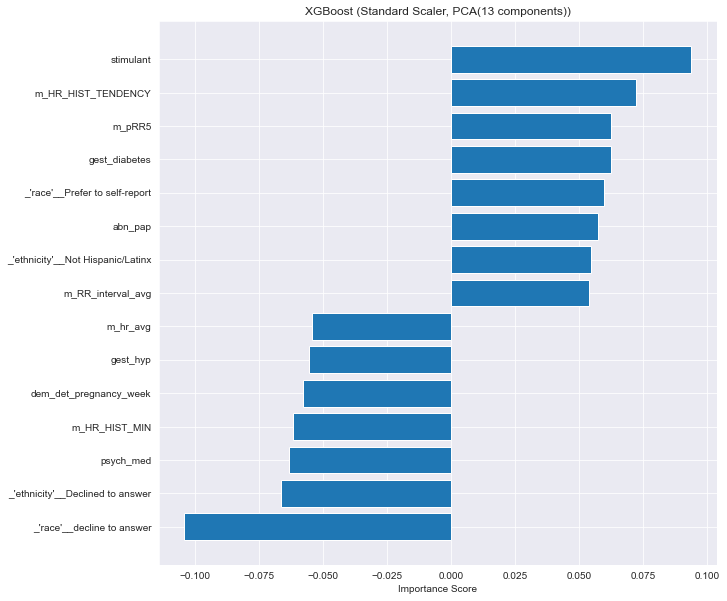

In [33]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

cols = X.columns

pca = PCA()
fs = pca.fit(X)
array = np.cumsum(fs.explained_variance_ratio_)

# Selecting number of principal components
K = np.argmax(array > 0.9)
fs = PCA(n_components=K).fit(X)
X = fs.transform(X)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='error', eta=1)

xgb.fit(X, y)

coefs_df = coefs_to_df(cols, xgb, fs, scaler, 'PCA', K, 'PCA')

coefs_df = coefs_df.reset_index().drop(columns = ['Model', 'Scaler', 'Feat Selection', 'Type', 'Num of Features']).T. \
                                        sort_values(by=0, ascending=False)

pos_coefs = coefs_df[0][0:8]
neg_coefs = coefs_df[0][-7:]

strongest_coefs = pd.concat([pos_coefs, neg_coefs], axis=0)
strongest_coefs = pd.DataFrame(strongest_coefs)
strongest_coefs.rename(columns = {0 : "Coefficient"}, inplace=True)

plt.figure(figsize=(10,10))
plt.barh(strongest_coefs.index, strongest_coefs["Coefficient"])
plt.gca().invert_yaxis()
plt.title("XGBoost (Standard Scaler, PCA(13 components))")
plt.savefig('feat_imp_xgb_pca.png',bbox_inches="tight")
plt.xlabel('Importance Score');

### Best LogisticRegression

In [29]:
X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

cols = X.columns

scaler = RobustScaler()

scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=cols)

lgr = LogisticRegression()

param_dict = {'penalty': ['none', 'l1', 'l2', 'elasticnet'], 'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 
              'C': loguniform(1e-5, 100), 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

grid = RandomizedSearchCV(lgr, param_dict)
grid.fit(X, y)
lgr = grid.best_estimator_
lgr

C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\model_

C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\liorn\Anaconda3\lib\site-packages\sklearn\model_selectio

LogisticRegression(C=0.009720752168221906, penalty='l1', solver='liblinear',
                   tol=1e-06)

In [30]:
all_scores = {'Train_Accuracy_CV': [], 'Val_Accuracy_CV': [], 'Train_F1_CV': [], 
             'Val_F1_CV': [], 'Val_Sensitivity_CV': [], 'Val_Specificity_CV': [], 'Val_AUC_CV': [], 'K': []}


fs = GenericUnivariateSelect(mode='fdr', param=0.7)

fs.fit(X, y)
X_fs = pd.DataFrame(fs.transform(X))
                        
K = sum(fs.get_support())
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

final_results = []

all_y_preds = []
all_y_true = []

for train_index, val_index in skf.split(X_fs, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    lgr.fit(X_train, y_train)
    y_pred_train = lgr.predict(X_train)
    y_pred_val = lgr.predict(X_val)
    
    all_y_preds.append(list(y_pred_val))
    all_y_true.append(list(y_val))
    
    all_scores['Train_Accuracy_CV'].append(accuracy_score(y_train, y_pred_train))
    all_scores['Val_Accuracy_CV'].append(accuracy_score(y_val, y_pred_val))
    all_scores['Train_F1_CV'].append(f1_score(y_train, y_pred_train, average='weighted'))
    all_scores['Val_F1_CV'].append(f1_score(y_val, y_pred_val, average='weighted'))
    all_scores['Val_Sensitivity_CV'].append(recall_score(y_val, y_pred_val, average='weighted'))
    all_scores['Val_Specificity_CV'].append(recall_score(y_val, y_pred_val, labels = [0], average='weighted'))
    all_scores['Val_AUC_CV'].append(roc_auc_score(y_val, y_pred_val))
    all_scores['K'].append(K)

# Averaging CV results of splits
for metric, score in all_scores.items():
    all_scores[metric] = np.mean(score)
    
all_y_preds = [item for elem in all_y_preds for item in elem]
all_y_true = [item for elem in all_y_true for item in elem]
    
final_results.append({'Model': lgr.__class__.__name__, 'scaler': scaler.__class__.__name__, 
                              'Feat Selection': 'FDR',
                              'Type': 'CV',
                              'Num of Features': all_scores['K'],
                              'Train_Accuracy_CV': all_scores['Train_Accuracy_CV'], 
                              'Val_Accuracy_CV': all_scores['Val_Accuracy_CV'], 
                              'Train_F1_CV': all_scores['Train_F1_CV'], 
                              'Val_F1_CV': all_scores['Val_F1_CV'], 
                              'Val_Sensitivity_CV': all_scores['Val_Sensitivity_CV'], 
                              'Val_Specificity_CV': all_scores['Val_Specificity_CV'], 
                              'Val_AUC_CV': all_scores['Val_AUC_CV']})
pd.DataFrame(final_results).set_index(['Model'])

,scaler,Feat Selection,Type,Num of Features,Train_Accuracy_CV,Val_Accuracy_CV,Train_F1_CV,Val_F1_CV,Val_Sensitivity_CV,Val_Specificity_CV,Val_AUC_CV
Model,,,,,,,,,,,
LogisticRegression,RobustScaler,FDR,CV,2.0,0.765947,0.765,0.664448,0.664524,0.765,1.0,0.5


#### Logistic Regression Feature Importance (all data, no CV, PCA)

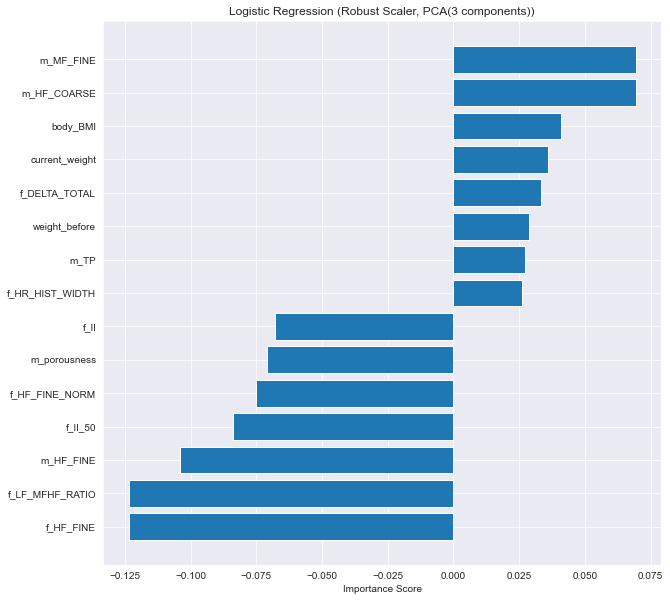

In [31]:
X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

scaler = RobustScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=cols)

cols = X.columns

pca = PCA()
fs = pca.fit(X)
array = np.cumsum(fs.explained_variance_ratio_)

# Selecting number of principal components
K = np.argmax(array > 0.9)
fs = PCA(n_components=K).fit(X)
X = fs.transform(X)

lgr = LogisticRegression(max_iter=5000)
lgr.fit(X, y)

coefs_df = coefs_to_df(cols, lgr, fs, scaler, 'PCA', K, 'PCA')

coefs_df = coefs_df.reset_index().drop(columns = ['Model', 'Scaler', 'Feat Selection', 'Type', 'Num of Features']).T. \
                                        sort_values(by=0, ascending=False)

pos_coefs = coefs_df[0][0:8]
neg_coefs = coefs_df[0][-7:]

strongest_coefs = pd.concat([pos_coefs, neg_coefs], axis=0)
strongest_coefs = pd.DataFrame(strongest_coefs)
strongest_coefs.rename(columns = {0 : "Coefficient"}, inplace=True)

plt.figure(figsize=(10,10))
plt.barh(strongest_coefs.index, strongest_coefs["Coefficient"])
plt.gca().invert_yaxis()
plt.title("Logistic Regression (Robust Scaler, PCA(3 components))")
plt.savefig('feat_imp_lgr_pca.png',bbox_inches="tight")
plt.xlabel('Importance Score');

#### Logistic Regression Feature Importance (all data, no CV, Lasso)

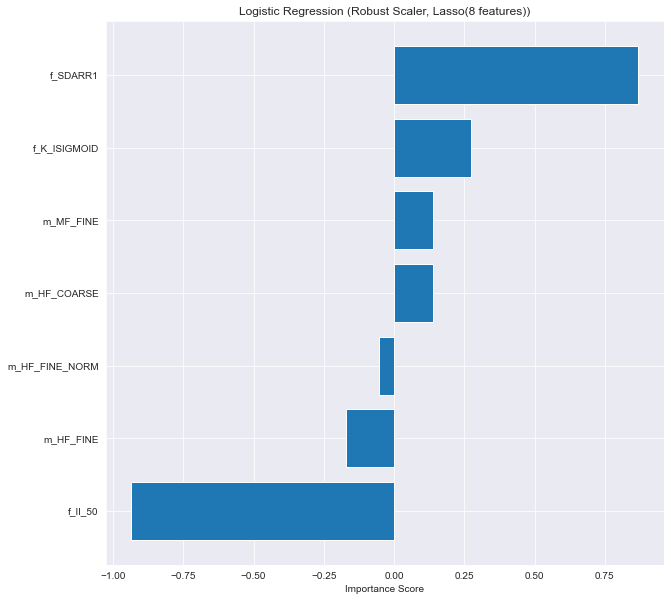

In [32]:
X = df_feats.drop(columns = ['study_id'])
y = df_targets['cesdclinmA'].astype(int)

scaler = RobustScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=cols)

cols = X.columns

fs = SelectFromModel(Lasso(alpha=0.15, max_iter=5000, tol=0.2))
fs.fit(X, y)
X = fs.transform(X)
K = sum(fs.get_support())

lgr = LogisticRegression(max_iter=5000)
lgr.fit(X, y)

coefs_df = coefs_to_df(cols, lgr, fs, scaler, 'Lasso', K,)

coefs_df = coefs_df.reset_index().drop(columns = ['Model', 'Scaler', 'Feat Selection', 'Type', 'Num of Features']).T. \
                                        sort_values(by=0, ascending=False)

pos_coefs = coefs_df[0][0:4]
neg_coefs = coefs_df[0][-3:]

strongest_coefs = pd.concat([pos_coefs, neg_coefs], axis=0)
strongest_coefs = pd.DataFrame(strongest_coefs)
strongest_coefs.rename(columns = {0 : "Coefficient"}, inplace=True)

plt.figure(figsize=(10,10))
plt.barh(strongest_coefs.index, strongest_coefs["Coefficient"])
plt.gca().invert_yaxis()
plt.title("Logistic Regression (Robust Scaler, Lasso(8 features))")
plt.savefig('feat_imp_lgr_lasso.png',bbox_inches="tight")
plt.xlabel('Importance Score');